# Polygonisation des bâtiments dans les images aeriennes

In [ ]:
import os
import cv2
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Polygon
from shapely.ops import unary_union
from PIL import Image
import glob
import zipfile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Modelisation/NEW2-AerialImageDataset.zip

Archive:  /content/drive/MyDrive/Modelisation/NEW2-AerialImageDataset.zip
   creating: AerialImageDataset/
   creating: AerialImageDataset/test/
   creating: AerialImageDataset/test/images/
  inflating: AerialImageDataset/test/images/bellingham1.tif  
  inflating: AerialImageDataset/test/images/bellingham10.tif  
  inflating: AerialImageDataset/test/images/bellingham11.tif  
  inflating: AerialImageDataset/test/images/bellingham12.tif  
  inflating: AerialImageDataset/test/images/bellingham13.tif  
  inflating: AerialImageDataset/test/images/bellingham14.tif  
  inflating: AerialImageDataset/test/images/bellingham15.tif  
  inflating: AerialImageDataset/test/images/bellingham16.tif  
  inflating: AerialImageDataset/test/images/bellingham17.tif  
  inflating: AerialImageDataset/test/images/bellingham18.tif  
  inflating: AerialImageDataset/test/images/bellingham19.tif  
  inflating: AerialImageDataset/test/images/bellingham2.tif  
  inflating: AerialImageDataset/test/images/bellingham20

In [ ]:
# CROP IMAGES
import numpy as np
import cv2
import os
from tqdm import tqdm

# Function to crop large images and masks into smaller patches
def crop_images_and_masks(image_path, mask_path, patch_size=256, stride=256, output_dir="output"):
  """
  Crop large images and masks into smaller patches.

  Args:
  image_path (str): Path to the large image.
  mask_path (str): Path to the corresponding large mask.
  patch_size (int): Size of each patch.
  stride (int): Stride for sliding the crop window.
  output_dir (str): Directory to save the cropped images and masks.
  """
  # Load the image and mask
  image = cv2.imread(image_path)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

  # Ensure output directories exist
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)
      os.makedirs(os.path.join(output_dir, 'images'))
      os.makedirs(os.path.join(output_dir, 'masks'))

  img_output = os.path.join(output_dir, 'images')
  mask_output = os.path.join(output_dir, 'masks')

  image_name = os.path.basename(image_path).split('.')[0]
  mask_name = os.path.basename(mask_path).split('.')[0]

  # Get dimensions of the image (and mask)
  height, width = image.shape[:2]

  # Crop patches from the image and mask
  patch_id = 0
  for y in range(0, height - patch_size + 1, stride):
      for x in range(0, width - patch_size + 1, stride):
          image_patch = image[y:y+patch_size, x:x+patch_size]
          mask_patch = mask[y:y+patch_size, x:x+patch_size]

          # Save cropped patches
          cv2.imwrite(os.path.join(img_output, f"{image_name}_patch_{patch_id}.png"), image_patch)
          cv2.imwrite(os.path.join(mask_output, f"{mask_name}_patch_{patch_id}.png"), mask_patch)
          patch_id += 1

  print(f"Processed {patch_id} patches.")

In [ ]:
lst_images = glob.glob('/content/AerialImageDataset/train/images/*.tif')
print(len(lst_images))

180


In [ ]:
for image_path in tqdm(lst_images):
  mask_path = image_path.replace('images', 'gt')
  crop_images_and_masks(image_path, mask_path, patch_size=256, stride=256, output_dir="cropped_data")

  1%|          | 1/180 [00:01<04:15,  1.43s/it]

Processed 361 patches.


  1%|          | 2/180 [00:02<04:03,  1.37s/it]

Processed 361 patches.


  2%|▏         | 3/180 [00:04<04:05,  1.39s/it]

Processed 361 patches.


  2%|▏         | 4/180 [00:05<04:05,  1.39s/it]

Processed 361 patches.


  3%|▎         | 5/180 [00:07<04:43,  1.62s/it]

Processed 361 patches.


  3%|▎         | 6/180 [00:08<04:25,  1.52s/it]

Processed 361 patches.


  4%|▍         | 7/180 [00:10<04:11,  1.45s/it]

Processed 361 patches.


  4%|▍         | 8/180 [00:11<04:07,  1.44s/it]

Processed 361 patches.


  5%|▌         | 9/180 [00:12<04:01,  1.41s/it]

Processed 361 patches.


  6%|▌         | 10/180 [00:14<03:51,  1.36s/it]

Processed 361 patches.


  6%|▌         | 11/180 [00:15<04:07,  1.47s/it]

Processed 361 patches.


  7%|▋         | 12/180 [00:17<04:19,  1.55s/it]

Processed 361 patches.


  7%|▋         | 13/180 [00:18<04:04,  1.46s/it]

Processed 361 patches.


  8%|▊         | 14/180 [00:20<03:59,  1.44s/it]

Processed 361 patches.


  8%|▊         | 15/180 [00:21<03:51,  1.40s/it]

Processed 361 patches.


  9%|▉         | 16/180 [00:22<03:47,  1.38s/it]

Processed 361 patches.


  9%|▉         | 17/180 [00:24<03:45,  1.39s/it]

Processed 361 patches.


 10%|█         | 18/180 [00:25<03:38,  1.35s/it]

Processed 361 patches.


 11%|█         | 19/180 [00:26<03:35,  1.34s/it]

Processed 361 patches.


 11%|█         | 20/180 [00:28<03:37,  1.36s/it]

Processed 361 patches.


 12%|█▏        | 21/180 [00:30<03:53,  1.47s/it]

Processed 361 patches.


 12%|█▏        | 22/180 [00:31<03:45,  1.42s/it]

Processed 361 patches.


 13%|█▎        | 23/180 [00:32<03:37,  1.38s/it]

Processed 361 patches.


 13%|█▎        | 24/180 [00:34<03:33,  1.37s/it]

Processed 361 patches.


 14%|█▍        | 25/180 [00:35<03:35,  1.39s/it]

Processed 361 patches.


 14%|█▍        | 26/180 [00:36<03:32,  1.38s/it]

Processed 361 patches.


 15%|█▌        | 27/180 [00:38<03:45,  1.48s/it]

Processed 361 patches.


 16%|█▌        | 28/180 [00:40<03:54,  1.54s/it]

Processed 361 patches.


 16%|█▌        | 29/180 [00:41<03:44,  1.48s/it]

Processed 361 patches.


 17%|█▋        | 30/180 [00:42<03:31,  1.41s/it]

Processed 361 patches.


 17%|█▋        | 31/180 [00:44<03:26,  1.38s/it]

Processed 361 patches.


 18%|█▊        | 32/180 [00:45<03:20,  1.35s/it]

Processed 361 patches.


 18%|█▊        | 33/180 [00:46<03:17,  1.34s/it]

Processed 361 patches.


 19%|█▉        | 34/180 [00:48<03:15,  1.34s/it]

Processed 361 patches.


 19%|█▉        | 35/180 [00:49<03:30,  1.45s/it]

Processed 361 patches.


 20%|██        | 36/180 [00:51<03:40,  1.53s/it]

Processed 361 patches.


 21%|██        | 37/180 [00:52<03:30,  1.47s/it]

Processed 361 patches.


 21%|██        | 38/180 [00:54<03:26,  1.45s/it]

Processed 361 patches.


 22%|██▏       | 39/180 [00:55<03:17,  1.40s/it]

Processed 361 patches.


 22%|██▏       | 40/180 [00:56<03:16,  1.40s/it]

Processed 361 patches.


 23%|██▎       | 41/180 [00:58<03:11,  1.38s/it]

Processed 361 patches.


 23%|██▎       | 42/180 [00:59<03:06,  1.35s/it]

Processed 361 patches.


 24%|██▍       | 43/180 [01:00<03:00,  1.32s/it]

Processed 361 patches.


 24%|██▍       | 44/180 [01:02<03:01,  1.34s/it]

Processed 361 patches.


 25%|██▌       | 45/180 [01:03<02:59,  1.33s/it]

Processed 361 patches.


 26%|██▌       | 46/180 [01:04<02:59,  1.34s/it]

Processed 361 patches.


 26%|██▌       | 47/180 [01:06<02:58,  1.34s/it]

Processed 361 patches.


 27%|██▋       | 48/180 [01:07<02:56,  1.34s/it]

Processed 361 patches.


 27%|██▋       | 49/180 [01:08<02:54,  1.33s/it]

Processed 361 patches.


 28%|██▊       | 50/180 [01:10<02:51,  1.32s/it]

Processed 361 patches.


 28%|██▊       | 51/180 [01:11<02:53,  1.34s/it]

Processed 361 patches.


 29%|██▉       | 52/180 [01:13<03:07,  1.46s/it]

Processed 361 patches.


 29%|██▉       | 53/180 [01:14<02:59,  1.42s/it]

Processed 361 patches.


 30%|███       | 54/180 [01:15<02:56,  1.40s/it]

Processed 361 patches.


 31%|███       | 55/180 [01:17<03:07,  1.50s/it]

Processed 361 patches.


 31%|███       | 56/180 [01:19<03:14,  1.57s/it]

Processed 361 patches.


 32%|███▏      | 57/180 [01:20<03:05,  1.50s/it]

Processed 361 patches.


 32%|███▏      | 58/180 [01:22<02:58,  1.46s/it]

Processed 361 patches.


 33%|███▎      | 59/180 [01:23<02:52,  1.43s/it]

Processed 361 patches.


 33%|███▎      | 60/180 [01:24<02:47,  1.40s/it]

Processed 361 patches.


 34%|███▍      | 61/180 [01:26<02:47,  1.41s/it]

Processed 361 patches.


 34%|███▍      | 62/180 [01:27<02:41,  1.37s/it]

Processed 361 patches.


 35%|███▌      | 63/180 [01:29<02:52,  1.47s/it]

Processed 361 patches.


 36%|███▌      | 64/180 [01:30<02:57,  1.53s/it]

Processed 361 patches.


 36%|███▌      | 65/180 [01:32<02:46,  1.45s/it]

Processed 361 patches.


 37%|███▋      | 66/180 [01:33<02:53,  1.52s/it]

Processed 361 patches.


 37%|███▋      | 67/180 [01:35<02:44,  1.46s/it]

Processed 361 patches.


 38%|███▊      | 68/180 [01:36<02:54,  1.56s/it]

Processed 361 patches.


 38%|███▊      | 69/180 [01:38<02:44,  1.49s/it]

Processed 361 patches.


 39%|███▉      | 70/180 [01:39<02:50,  1.55s/it]

Processed 361 patches.


 39%|███▉      | 71/180 [01:41<02:44,  1.51s/it]

Processed 361 patches.


 40%|████      | 72/180 [01:42<02:37,  1.46s/it]

Processed 361 patches.


 41%|████      | 73/180 [01:44<02:33,  1.44s/it]

Processed 361 patches.


 41%|████      | 74/180 [01:45<02:28,  1.40s/it]

Processed 361 patches.


 42%|████▏     | 75/180 [01:47<02:37,  1.50s/it]

Processed 361 patches.


 42%|████▏     | 76/180 [01:48<02:28,  1.43s/it]

Processed 361 patches.


 43%|████▎     | 77/180 [01:49<02:23,  1.39s/it]

Processed 361 patches.


 43%|████▎     | 78/180 [01:50<02:19,  1.36s/it]

Processed 361 patches.


 44%|████▍     | 79/180 [01:52<02:13,  1.33s/it]

Processed 361 patches.


 44%|████▍     | 80/180 [01:53<02:24,  1.44s/it]

Processed 361 patches.


 45%|████▌     | 81/180 [01:55<02:17,  1.39s/it]

Processed 361 patches.


 46%|████▌     | 82/180 [01:56<02:12,  1.35s/it]

Processed 361 patches.


 46%|████▌     | 83/180 [01:57<02:09,  1.34s/it]

Processed 361 patches.


 47%|████▋     | 84/180 [01:59<02:08,  1.34s/it]

Processed 361 patches.


 47%|████▋     | 85/180 [02:00<02:06,  1.34s/it]

Processed 361 patches.


 48%|████▊     | 86/180 [02:02<02:15,  1.44s/it]

Processed 361 patches.


 48%|████▊     | 87/180 [02:03<02:10,  1.41s/it]

Processed 361 patches.


 49%|████▉     | 88/180 [02:04<02:04,  1.36s/it]

Processed 361 patches.


 49%|████▉     | 89/180 [02:06<02:14,  1.48s/it]

Processed 361 patches.


 50%|█████     | 90/180 [02:08<02:19,  1.55s/it]

Processed 361 patches.


 51%|█████     | 91/180 [02:09<02:12,  1.49s/it]

Processed 361 patches.


 51%|█████     | 92/180 [02:10<02:07,  1.45s/it]

Processed 361 patches.


 52%|█████▏    | 93/180 [02:12<02:03,  1.42s/it]

Processed 361 patches.


 52%|█████▏    | 94/180 [02:13<02:00,  1.40s/it]

Processed 361 patches.


 53%|█████▎    | 95/180 [02:14<01:57,  1.38s/it]

Processed 361 patches.


 53%|█████▎    | 96/180 [02:16<01:55,  1.37s/it]

Processed 361 patches.


 54%|█████▍    | 97/180 [02:17<01:51,  1.35s/it]

Processed 361 patches.


 54%|█████▍    | 98/180 [02:18<01:50,  1.35s/it]

Processed 361 patches.


 55%|█████▌    | 99/180 [02:20<01:48,  1.33s/it]

Processed 361 patches.


 56%|█████▌    | 100/180 [02:21<01:46,  1.33s/it]

Processed 361 patches.


 56%|█████▌    | 101/180 [02:23<01:53,  1.44s/it]

Processed 361 patches.


 57%|█████▋    | 102/180 [02:24<01:51,  1.42s/it]

Processed 361 patches.


 57%|█████▋    | 103/180 [02:25<01:47,  1.39s/it]

Processed 361 patches.


 58%|█████▊    | 104/180 [02:27<01:52,  1.48s/it]

Processed 361 patches.


 58%|█████▊    | 105/180 [02:29<01:56,  1.55s/it]

Processed 361 patches.


 59%|█████▉    | 106/180 [02:30<01:57,  1.59s/it]

Processed 361 patches.


 59%|█████▉    | 107/180 [02:32<01:49,  1.50s/it]

Processed 361 patches.


 60%|██████    | 108/180 [02:34<01:53,  1.58s/it]

Processed 361 patches.


 61%|██████    | 109/180 [02:35<01:48,  1.52s/it]

Processed 361 patches.


 61%|██████    | 110/180 [02:36<01:43,  1.47s/it]

Processed 361 patches.


 62%|██████▏   | 111/180 [02:38<01:39,  1.44s/it]

Processed 361 patches.


 62%|██████▏   | 112/180 [02:39<01:35,  1.40s/it]

Processed 361 patches.


 63%|██████▎   | 113/180 [02:40<01:35,  1.42s/it]

Processed 361 patches.


 63%|██████▎   | 114/180 [02:42<01:38,  1.49s/it]

Processed 361 patches.


 64%|██████▍   | 115/180 [02:44<01:40,  1.55s/it]

Processed 361 patches.


 64%|██████▍   | 116/180 [02:45<01:41,  1.59s/it]

Processed 361 patches.


 65%|██████▌   | 117/180 [02:47<01:38,  1.57s/it]

Processed 361 patches.


 66%|██████▌   | 118/180 [02:49<01:39,  1.61s/it]

Processed 361 patches.


 66%|██████▌   | 119/180 [02:50<01:40,  1.65s/it]

Processed 361 patches.


 67%|██████▋   | 120/180 [02:52<01:39,  1.67s/it]

Processed 361 patches.


 67%|██████▋   | 121/180 [02:54<01:39,  1.68s/it]

Processed 361 patches.


 68%|██████▊   | 122/180 [02:55<01:31,  1.58s/it]

Processed 361 patches.


 68%|██████▊   | 123/180 [02:57<01:31,  1.61s/it]

Processed 361 patches.


 69%|██████▉   | 124/180 [02:59<01:32,  1.64s/it]

Processed 361 patches.


 69%|██████▉   | 125/180 [03:00<01:25,  1.56s/it]

Processed 361 patches.


 70%|███████   | 126/180 [03:02<01:26,  1.59s/it]

Processed 361 patches.


 71%|███████   | 127/180 [03:03<01:20,  1.51s/it]

Processed 361 patches.


 71%|███████   | 128/180 [03:05<01:21,  1.56s/it]

Processed 361 patches.


 72%|███████▏  | 129/180 [03:06<01:22,  1.63s/it]

Processed 361 patches.


 72%|███████▏  | 130/180 [03:08<01:16,  1.54s/it]

Processed 361 patches.


 73%|███████▎  | 131/180 [03:09<01:11,  1.47s/it]

Processed 361 patches.


 73%|███████▎  | 132/180 [03:10<01:08,  1.43s/it]

Processed 361 patches.


 74%|███████▍  | 133/180 [03:12<01:05,  1.38s/it]

Processed 361 patches.


 74%|███████▍  | 134/180 [03:13<01:07,  1.47s/it]

Processed 361 patches.


 75%|███████▌  | 135/180 [03:15<01:09,  1.54s/it]

Processed 361 patches.


 76%|███████▌  | 136/180 [03:16<01:04,  1.46s/it]

Processed 361 patches.


 76%|███████▌  | 137/180 [03:18<01:05,  1.53s/it]

Processed 361 patches.


 77%|███████▋  | 138/180 [03:19<01:01,  1.47s/it]

Processed 361 patches.


 77%|███████▋  | 139/180 [03:21<01:03,  1.54s/it]

Processed 361 patches.


 78%|███████▊  | 140/180 [03:22<00:58,  1.46s/it]

Processed 361 patches.


 78%|███████▊  | 141/180 [03:24<00:59,  1.54s/it]

Processed 361 patches.


 79%|███████▉  | 142/180 [03:26<01:00,  1.58s/it]

Processed 361 patches.


 79%|███████▉  | 143/180 [03:27<00:55,  1.51s/it]

Processed 361 patches.


 80%|████████  | 144/180 [03:28<00:52,  1.45s/it]

Processed 361 patches.


 81%|████████  | 145/180 [03:30<00:49,  1.42s/it]

Processed 361 patches.


 81%|████████  | 146/180 [03:31<00:47,  1.39s/it]

Processed 361 patches.


 82%|████████▏ | 147/180 [03:33<00:49,  1.49s/it]

Processed 361 patches.


 82%|████████▏ | 148/180 [03:34<00:48,  1.53s/it]

Processed 361 patches.


 83%|████████▎ | 149/180 [03:36<00:45,  1.46s/it]

Processed 361 patches.


 83%|████████▎ | 150/180 [03:37<00:46,  1.55s/it]

Processed 361 patches.


 84%|████████▍ | 151/180 [03:39<00:45,  1.58s/it]

Processed 361 patches.


 84%|████████▍ | 152/180 [03:41<00:45,  1.61s/it]

Processed 361 patches.


 85%|████████▌ | 153/180 [03:42<00:44,  1.64s/it]

Processed 361 patches.


 86%|████████▌ | 154/180 [03:44<00:40,  1.56s/it]

Processed 361 patches.


 86%|████████▌ | 155/180 [03:45<00:36,  1.48s/it]

Processed 361 patches.


 87%|████████▋ | 156/180 [03:46<00:34,  1.43s/it]

Processed 361 patches.


 87%|████████▋ | 157/180 [03:48<00:34,  1.51s/it]

Processed 361 patches.


 88%|████████▊ | 158/180 [03:50<00:34,  1.57s/it]

Processed 361 patches.


 88%|████████▊ | 159/180 [03:51<00:31,  1.49s/it]

Processed 361 patches.


 89%|████████▉ | 160/180 [03:52<00:28,  1.42s/it]

Processed 361 patches.


 89%|████████▉ | 161/180 [03:54<00:28,  1.52s/it]

Processed 361 patches.


 90%|█████████ | 162/180 [03:56<00:26,  1.47s/it]

Processed 361 patches.


 91%|█████████ | 163/180 [03:57<00:23,  1.41s/it]

Processed 361 patches.


 91%|█████████ | 164/180 [03:58<00:22,  1.38s/it]

Processed 361 patches.


 92%|█████████▏| 165/180 [04:00<00:22,  1.47s/it]

Processed 361 patches.


 92%|█████████▏| 166/180 [04:01<00:19,  1.41s/it]

Processed 361 patches.


 93%|█████████▎| 167/180 [04:03<00:19,  1.49s/it]

Processed 361 patches.


 93%|█████████▎| 168/180 [04:04<00:18,  1.56s/it]

Processed 361 patches.


 94%|█████████▍| 169/180 [04:06<00:17,  1.59s/it]

Processed 361 patches.


 94%|█████████▍| 170/180 [04:08<00:16,  1.61s/it]

Processed 361 patches.


 95%|█████████▌| 171/180 [04:09<00:13,  1.53s/it]

Processed 361 patches.


 96%|█████████▌| 172/180 [04:11<00:12,  1.59s/it]

Processed 361 patches.


 96%|█████████▌| 173/180 [04:13<00:11,  1.65s/it]

Processed 361 patches.


 97%|█████████▋| 174/180 [04:14<00:09,  1.66s/it]

Processed 361 patches.


 97%|█████████▋| 175/180 [04:16<00:07,  1.54s/it]

Processed 361 patches.


 98%|█████████▊| 176/180 [04:17<00:05,  1.47s/it]

Processed 361 patches.


 98%|█████████▊| 177/180 [04:18<00:04,  1.43s/it]

Processed 361 patches.


 99%|█████████▉| 178/180 [04:20<00:03,  1.53s/it]

Processed 361 patches.


 99%|█████████▉| 179/180 [04:21<00:01,  1.46s/it]

Processed 361 patches.


100%|██████████| 180/180 [04:23<00:00,  1.46s/it]

Processed 361 patches.


### Vertices

In [ ]:
# Function to extract vertices from a binary mask (contours)
def extract_vertices_from_mask(mask):
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    vertices = [(point[0][0], point[0][1]) for contour in contours for point in contour]
    return np.array(vertices)

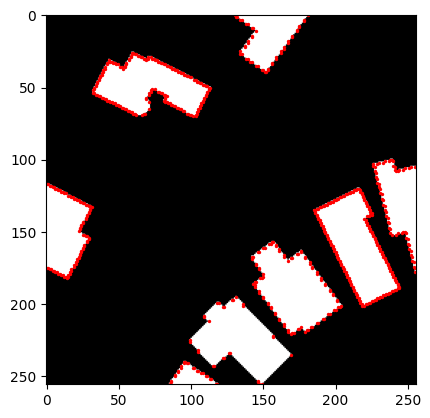

In [ ]:
mask_patch = cv2.imread('/content/cropped_data/masks/austin10_patch_319.png', cv2.IMREAD_GRAYSCALE)
vertices = extract_vertices_from_mask(mask_patch)

plt.imshow(mask_patch, cmap='gray')
plt.scatter(vertices[:, 0], vertices[:, 1], color='red', s=2)
plt.show()

## Dataset

In [ ]:
class BuildingDataset(Dataset):
    def __init__(self, image_paths, mask_paths, patch_size=256):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.patch_size = patch_size
        self.valid_data = []

        # Filter out empty masks during dataset initialization
        for img_path, mask_path in zip(image_paths, mask_paths):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Binary mask
            vertices = extract_vertices_from_mask(mask)
            if len(vertices) > 0:  # Only keep non-empty masks
                self.valid_data.append((img_path, mask_path))

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        img_path, mask_path = self.valid_data[idx]

        image = cv2.imread(img_path)  # BGR format
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Binary mask

        # Resize image and mask to the target size (e.g., 256x256)
        image = cv2.resize(image, (self.patch_size, self.patch_size))  # Resize to patch_size
        mask = cv2.resize(mask, (self.patch_size, self.patch_size), interpolation=cv2.INTER_NEAREST)  # Resize mask

        # Normalize and convert image to tensor
        image = image / 255.0
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)

        # Extract vertices and convert to tensor
        vertices = extract_vertices_from_mask(mask)
        vertices = torch.tensor(vertices, dtype=torch.float32)

        return image, vertices

In [ ]:
def split_data(image_dir, mask_dir, train_size=6000, val_size=600, test_size=600):
    # Get all image and mask paths
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
    mask_paths = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')]

    print(f"Total images: {len(image_paths)}, Total masks: {len(mask_paths)}")

    # Ensure we have enough images in the directory
    assert len(image_paths) >= (train_size + val_size + test_size), "Not enough images in the dataset"

    # Shuffle the list of image paths for random splitting
    combined = list(zip(image_paths, mask_paths))
    random.shuffle(combined)
    image_paths, mask_paths = zip(*combined)

    # Split the dataset into train, validation, and test sets
    train_images = image_paths[:train_size]
    train_masks = mask_paths[:train_size]
    val_images = image_paths[train_size:train_size + val_size]
    val_masks = mask_paths[train_size:train_size + val_size]
    test_images = image_paths[train_size + val_size:train_size + val_size + test_size]
    test_masks = mask_paths[train_size + val_size:train_size + val_size + test_size]

    print(f"Train images: {len(train_images)}, Val images: {len(val_images)}, Test images: {len(test_images)}")

    return train_images, train_masks, val_images, val_masks, test_images, test_masks

In [ ]:
# Collate function: Pad the target vertices to the same size
def collate_fn(batch):
    max_vertices = max([len(item[1]) for item in batch])

    images = []
    padded_vertices = []

    for img, vertices in batch:
        padded_vertices.append(torch.cat([vertices, torch.zeros(max_vertices - len(vertices), 2)], dim=0))
        images.append(img)

    images = torch.stack(images, 0)  # (batch_size, C, H, W)
    padded_vertices = torch.stack(padded_vertices, 0)  # (batch_size, max_vertices, 2)

    return images, padded_vertices

In [ ]:
train_images, train_masks, val_images, val_masks, test_images, test_masks = split_data("/content/cropped_data/images", "/content/cropped_data/masks")

In [ ]:
# Create datasets and dataloaders for train, validation, and test
train_dataset = BuildingDataset(train_images, train_masks)
val_dataset = BuildingDataset(val_images, val_masks)
test_dataset = BuildingDataset(test_images, test_masks)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
# --- Dynamically calculate encoder output size ---
dummy_encoder = nn.Sequential(*list(models.resnet34(weights='IMAGENET1K_V1').children())[:-2])
dummy_input = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    dummy_output = dummy_encoder(dummy_input)

flattened_features_size = dummy_output.view(dummy_output.size(0), -1).shape[1]
print(f"Dynamically calculated flattened features size from encoder: {flattened_features_size}")

Dynamically calculated flattened features size from encoder: 32768


## Model

In [ ]:
# ResNet34 with two branches: TSD regressor and Gaussian density regressor
class VertexAidedPolygonization(nn.Module):
    def __init__(self, max_vertices=100, encoder_output_features=flattened_features_size):
        super(VertexAidedPolygonization, self).__init__()

        # Using a simple CNN-based encoder with ResNet34
        resnet = models.resnet34(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # TSD regressor - Use the dynamically calculated size
        self.fc1_tsd = nn.Linear(encoder_output_features, 1024)
        self.fc2_tsd = nn.Linear(1024, max_vertices * 2)

        # Gaussian density regressor - Use the dynamically calculated size
        self.fc1_gaussian = nn.Linear(encoder_output_features, 1024)
        self.fc2_gaussian = nn.Linear(1024, max_vertices * 2)

    def forward(self, x):
        # Encoding using ResNet34 backbone
        features = self.encoder(x)

        # Flatten the output to feed into fully connected layers
        features = features.view(features.size(0), -1)

        # TSD regressor
        x_tsd = torch.relu(self.fc1_tsd(features))
        output_tsd = self.fc2_tsd(x_tsd)

        # Gaussian density regressor
        x_gaussian = torch.relu(self.fc1_gaussian(features))
        output_gaussian = self.fc2_gaussian(x_gaussian)

        # Reshape output to (batch_size, max_vertices, 2)
        output_tsd = output_tsd.view(x.size(0), -1, 2)
        output_gaussian = output_gaussian.view(x.size(0), -1, 2)

        return output_tsd, output_gaussian

In [ ]:
# Loss function for vertex prediction (TSD and Gaussian)
def vertex_loss(pred_tsd, pred_gaussian, target):
    pred_flat_tsd = pred_tsd.view(-1, 2)
    pred_flat_gaussian = pred_gaussian.view(-1, 2)
    target_flat = target.view(-1, 2)

    min_len = min(pred_flat_tsd.size(0), target_flat.size(0))

    loss_tsd = torch.mean((pred_flat_tsd[:min_len] - target_flat[:min_len]) ** 2)
    loss_gaussian = torch.mean((pred_flat_gaussian[:min_len] - target_flat[:min_len]) ** 2)

    return loss_tsd + loss_gaussian

In [ ]:
# Modified training loop with loss tracking
def train_model(model, train_loader, val_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, vertices in train_loader:
            optimizer.zero_grad()
            outputs_tsd, outputs_gaussian = model(images)
            loss = vertex_loss(outputs_tsd, outputs_gaussian, vertices)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, vertices in val_loader:
                outputs_tsd, outputs_gaussian = model(images)
                val_loss += vertex_loss(outputs_tsd, outputs_gaussian, vertices).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plotting the MSE loss curve - Moved outside the epoch loop
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Train MSE', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation MSE', marker='s')
    plt.title("MSE Loss Evolution over epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Mean Squared Error", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses

## Training

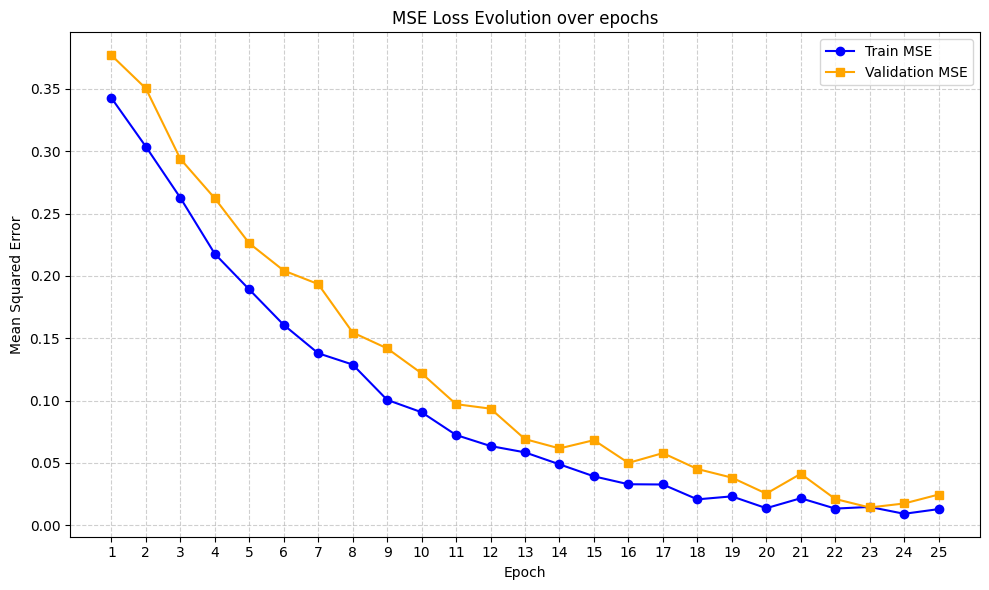

In [ ]:
model = VertexAidedPolygonization(max_vertices=100)
train_model(model, train_loader, val_loader, epochs=25)

In [ ]:
torch.save(model.state_dict(), "resnet.pth")

## Few resulting examples

In [ ]:
# Post-processing: Create polygons from predicted vertices
def generate_polygon_from_vertices(vertices):
    if len(vertices) < 3:  # Not enough points to form a polygon
        return None

    try:
        # Try to generate a convex hull (polygon) from the vertices
        hull = ConvexHull(vertices)
        return hull
    except:
        return None

# Function to visualize the predicted polygon on the image
def visualize_predicted_polygon(image, predicted_vertices):
    polygon = generate_polygon_from_vertices(predicted_vertices)

    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(image)
    plt.axis('off')

    # If a valid polygon is found, plot it
    if polygon:
        hull_points = polygon.points[polygon.vertices]
        #plt.fill(hull_points[:, 0], hull_points[:, 1], 'b-', alpha=0.3)  # Fill polygon with blue color
        plt.scatter(predicted_vertices[:, 0], predicted_vertices[:, 1], color='red', label='Predicted Vertices')  # Plot vertices in red
    else:
        plt.scatter(predicted_vertices[:, 0], predicted_vertices[:, 1], color='red', label='Predicted Vertices')

    # Set title and show the plot
    plt.title("Polygons and predicted vertices Drawn Over Image")
    plt.legend()
    plt.show()

# Function to run the model and visualize the predicted polygons
def predict_and_visualize(model, image_path, device): # Add device as an argument
    # Load and resize the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}. Skipping.")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with matplotlib
    image_resized = resize_image(image_rgb, target_size=(256, 256))

    # Convert the image to a tensor and normalize
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1)  # Convert to (C, H, W)
    image_tensor = image_tensor / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Get the predicted vertices from the model
    model.eval()
    with torch.no_grad():
        outputs_tsd, _ = model(image_tensor)

    # Post-process the predicted vertices (e.g., select the non-zero vertices)
    predicted_vertices = outputs_tsd[0].cpu().numpy()
    predicted_vertices = predicted_vertices[np.all(predicted_vertices != 0, axis=1)]  # Remove padding (zeros)

    # Visualize the predicted vertices and polygon on the image
    visualize_predicted_polygon(image_resized, predicted_vertices)


['/content/cropped_data/images/tyrol-w1_patch_74.png', '/content/cropped_data/images/vienna35_patch_21.png', '/content/cropped_data/images/vienna8_patch_286.png', '/content/cropped_data/images/vienna10_patch_214.png', '/content/cropped_data/images/vienna30_patch_270.png', '/content/cropped_data/images/tyrol-w32_patch_283.png', '/content/cropped_data/images/tyrol-w32_patch_142.png', '/content/cropped_data/images/vienna36_patch_280.png', '/content/cropped_data/images/kitsap5_patch_140.png', '/content/cropped_data/images/vienna17_patch_148.png']
/content/cropped_data/masks/tyrol-w1_patch_74.png


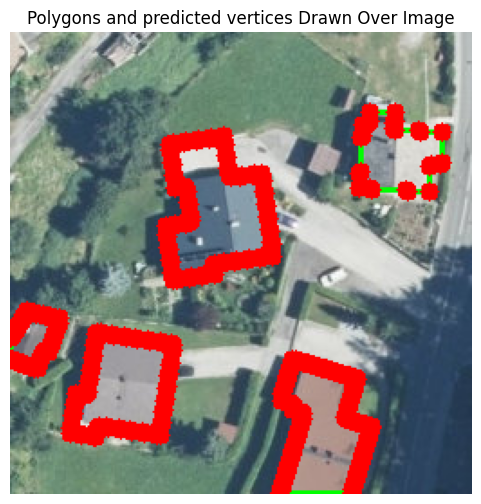

/content/cropped_data/masks/vienna35_patch_21.png


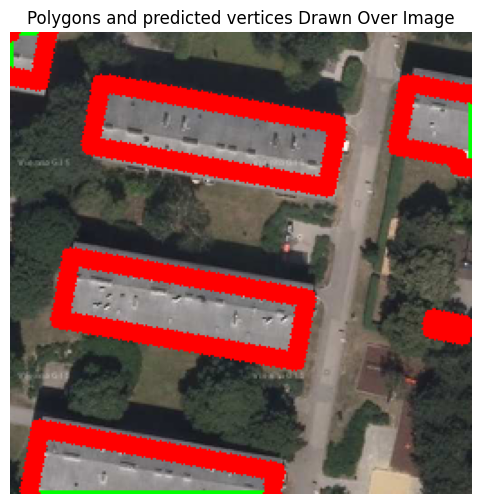

/content/cropped_data/masks/vienna8_patch_286.png


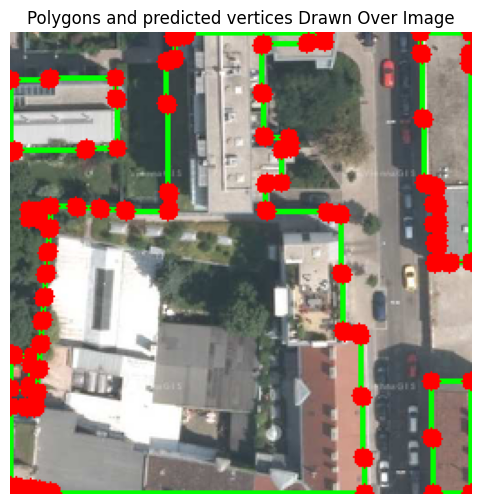

/content/cropped_data/masks/vienna10_patch_214.png


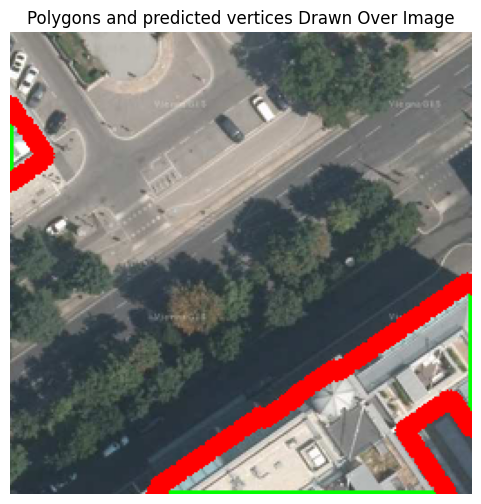

/content/cropped_data/masks/vienna30_patch_270.png


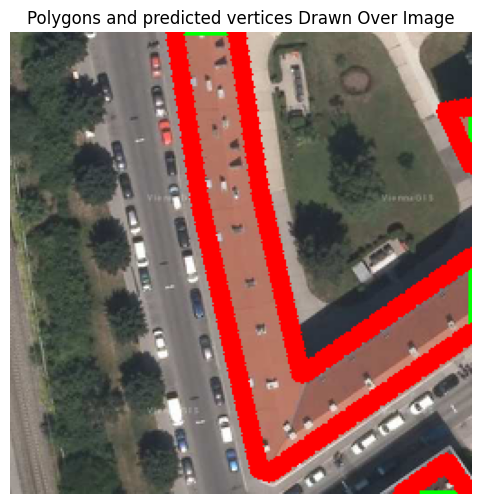

/content/cropped_data/masks/tyrol-w32_patch_283.png


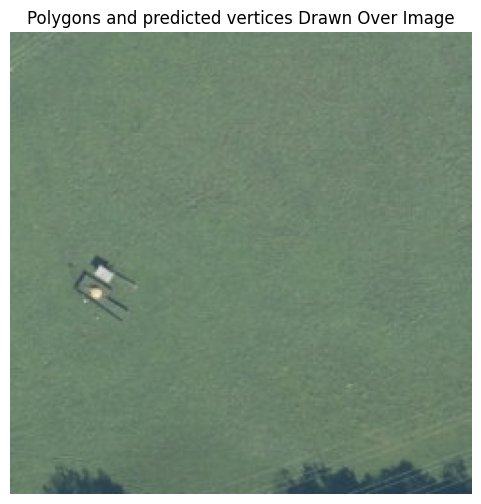

/content/cropped_data/masks/tyrol-w32_patch_142.png


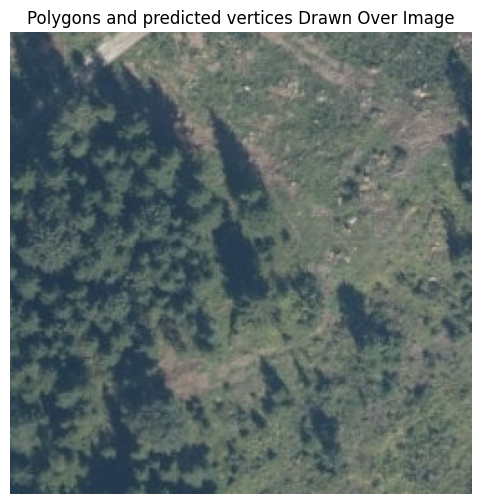

/content/cropped_data/masks/vienna36_patch_280.png


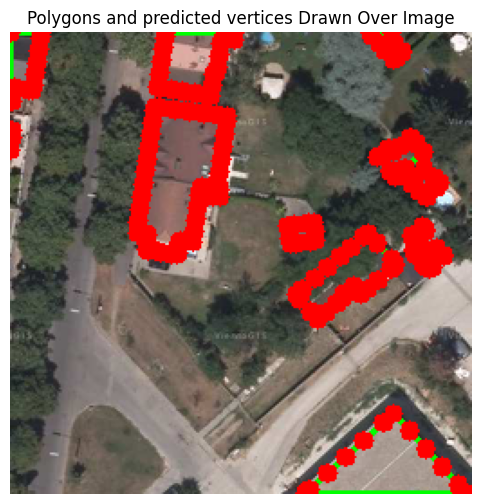

/content/cropped_data/masks/kitsap5_patch_140.png


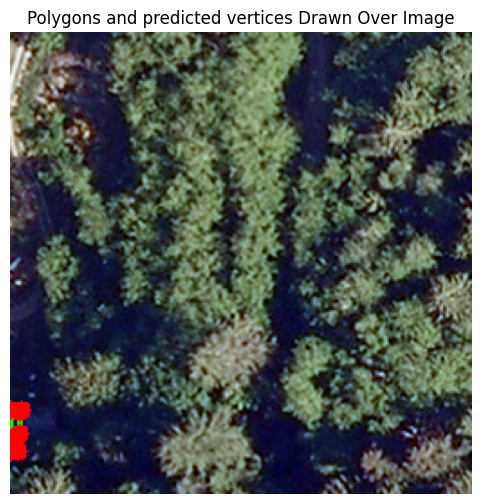

/content/cropped_data/masks/vienna17_patch_148.png


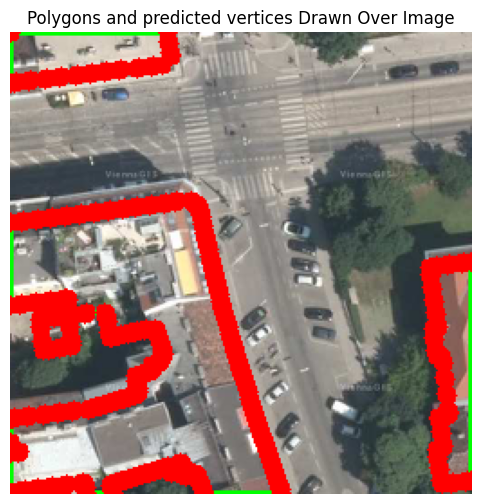

In [ ]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # Move the model to the selected device


path_to_images = "/content/cropped_data/test"

for image_name in os.listdir(path_to_images):
  image_path = os.path.join(path_to_images, image_name)
  predict_and_visualize(model, image_path, device) # Pass the device to the function